## Import des packages

In [1]:
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import SVC


from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Import des données et pipelines

<bound method Series.min of 124     188
90      184
89      177
114     175
122     175
       ... 
1970      1
2150      1
1906      1
1842      1
2015      1
Name: DURATION_CONTACT, Length: 1572, dtype: int64>


In [2]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier()) ])
rf = RandomForestClassifier()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## OverSampling

In [4]:
grid_params_rf = [{
                'criterion': ['entropy','gini'],
                'min_samples_leaf': [40,60, 80],
                'max_depth': [15,25,30],
                'min_samples_split': [3, 5, 10],
                'n_estimators' : [60, 70]
                }]
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
search = GridSearchCV(rf, grid_params_rf, n_jobs=-1, refit=True, verbose=True)
search.fit(X_train, y_train)
y_train

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.9min finished


array([1, 0, 0, ..., 0, 0, 0])

In [5]:
search.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 40,
 'min_samples_split': 10,
 'n_estimators': 60}

In [6]:
# WITH UNDER&OVER
good_rf = RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=40, min_samples_split=3, n_estimators=60)
good_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=40,
                       min_samples_split=3, n_estimators=60)

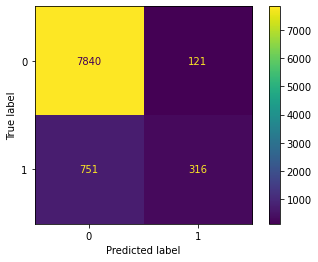

In [7]:
plot_confusion_matrix(good_rf,X_test, y_test)

In [8]:
r=[0.1,1,10]
pg_svm=[{'C':r, 'kernel':['linear']}]
#        {'C':r, 'gamma':r, 'kernel':['rbf']}]
svm = SVC(random_state=stg.RANDOM_STATE)

cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
gs_svm=GridSearchCV(estimator= svm,
               param_grid= pg_svm,
               scoring='recall',
                refit=True,
                n_jobs=-1,
               cv=2, verbose=True)
gs_svm.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    8.4s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 10.1min finished


KeyboardInterrupt: 

# SVM

In [14]:
y_true, y_pred = y_test, gs_svm.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7961
           1       0.42      0.86      0.56      1067

    accuracy                           0.84      9028
   macro avg       0.70      0.85      0.73      9028
weighted avg       0.91      0.84      0.86      9028



# RANDOM FOREST

In [6]:
y_true, y_pred = y_test, search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7961
           1       0.72      0.32      0.44      1067

    accuracy                           0.90      9028
   macro avg       0.82      0.65      0.69      9028
weighted avg       0.89      0.90      0.89      9028



# LOGREG

In [7]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
log_reg = LogisticRegression()
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
logreg_cv=GridSearchCV(estimator= log_reg,
               param_grid= grid,
               scoring='recall',
                refit=True,
                n_jobs=-1,
               cv=cv)
logreg_cv.fit(X_train, y_train)

/home/emilio/.cache/pypoetry/virtualenvs/productsubscription-eds-dm-8u1ePI5K-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [8]:
y_true, y_pred = y_test, logreg_cv.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7961
           1       0.66      0.40      0.50      1067

    accuracy                           0.90      9028
   macro avg       0.79      0.69      0.72      9028
weighted avg       0.89      0.90      0.89      9028



# GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
gbc = GradientBoostingClassifier()
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
gboost_cv=GridSearchCV(estimator= gbc,
               param_grid= grid,
                refit=True,
                n_jobs=-1,
               cv=cv)
gboost_cv.fit(X_resampled, y_resampled)